In [37]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from Rushi.PPO.utils import *
from Rushi.PPO.core import EarlyEnvs, EarlyEnvironment
from Rushi.PPO.constants import *
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from Rushi.PPO.ml import CategoricalMasked
from copy import deepcopy
import os
from evaluation.core import BaseStrategy
from evaluation.backTest import BackTest
import matplotlib.pyplot as plt

In [38]:
class DuelingQNetwork(nn.Module):
    def __init__(self,input_dim,output_dim) -> None:
        super().__init__()
        self.value_linear = nn.Sequential(nn.Linear(input_dim,input_dim*2), nn.ReLU(),
                                           nn.Linear(input_dim*2, input_dim*4), nn.ReLU(),
                                           nn.Linear(input_dim*4, 1)
                                           )
        self.advantage_linear = nn.Sequential(nn.Linear(input_dim,input_dim*2), nn.ReLU(),
                                           nn.Linear(input_dim*2, input_dim*4), nn.ReLU(),
                                           nn.Linear(input_dim*4, output_dim)
                                    )

    def forward(self,X):
        values = self.value_linear(X)
        advantage = self.advantage_linear(X)
        q_values = advantage - torch.mean(advantage,dim= -1, keepdim= True) + values
        return q_values
    

    def getAction(self,X, invalid_action_mask, eps = None):
        """
        X is (BS,obs_dim)
        """
        q_values = self.forward(X)
      

        if eps == None or np.random.random() > eps:
            q_values[invalid_action_mask] = -10000000
            chosen_values, chosen_actions = torch.max(q_values,dim = -1) 

            return chosen_values,chosen_actions        
        else:

            sample_probs = torch.ones_like(invalid_action_mask).float().to(X.device)
            sample_probs = CategoricalMasked(logits= sample_probs, masks= ~invalid_action_mask, device= X.device)
            chosen_actions = sample_probs.sample()
            chosen_values = torch.gather(input= q_values, dim= -1, index = chosen_actions.view(-1,1))[:,0]
            
            return chosen_values, chosen_actions


    def save(self,path):
        torch.save(self.state_dict(),path)
    
    def load(self,path):
        self.load_state_dict(torch.load(path))
        


In [39]:
df = pd.read_csv("data/5minute/APOLLOHOSP.csv")
df = interpolatorNotForDay(df= df, mode= "5minute")

total values interpolated = 1230


In [47]:
class QTrainer:
    def __init__(self,envs : EarlyEnvs,agent : DuelingQNetwork, device,logger : Logger, q_config : dict):
        self.envs = envs
        self.q_config = q_config
        self.agent = agent.to(device)
        self.lag_agent  = deepcopy(agent)
        self.device = device
        self.storage = []
        self.logger = logger
        
        self.best = dict(
            score = 0,
            model = None
        )
        self.logger.setMetricReportSteps(metric_name= "avg_reward", step_size= 1)
        self.logger.setMetricReportSteps(metric_name= "avg_profit", step_size= 1)
        self.logger.setMetricReportSteps(metric_name= "avg_length", step_size= 1)
        self.logger.setMetricReportSteps(metric_name= "avg_trades", step_size= 1)

        self.storage = self._initializeStorage()
        self.logger = logger
        self.mse_loss_function = nn.MSELoss(reduction= "none")
        
    
    def _initializeStorage(self):
        config = self.q_config
        num_steps,num_envs,observation_dim, action_space_dim = config["num_steps"], config["num_envs"], config["observation_dim"], config["action_space_dim"]



        obs = torch.zeros([num_steps, num_envs,observation_dim]).to(self.device)
        invalid_action_masks = torch.zeros([num_steps,num_envs,action_space_dim], dtype= torch.bool).to(self.device)
        actions  = torch.ones([num_steps,num_envs]).to(self.device)*-1
        rewards = torch.zeros([num_steps,num_envs]).to(self.device)
        dones = torch.zeros([num_steps,num_envs]).to(self.device)


        return  dict(
            obs = obs, actions = actions,invalid_action_masks = invalid_action_masks,
            rewards = rewards, dones = dones
        )
    

    def runUpdate(self, agent_optimizer, prev_state, eps):
        num_steps,num_envs = self.q_config["num_steps"], self.q_config["num_envs"]
        


        next_obs = prev_state["next_obs"]
        next_invalid_action_masks = prev_state["next_invalid_action_masks"]
        next_done = prev_state["next_done"]


        for step in range(num_steps):
            self.storage["obs"][step] = next_obs
            self.storage["dones"][step] = next_done

            with torch.no_grad():
                q_value,action =  self.agent.getAction(X = next_obs,invalid_action_mask= next_invalid_action_masks, eps= eps)
                
                # put episode logging code here
                self.storage["actions"][step] = action
                env_step = self.envs.step(action.cpu().numpy())

                next_obs, reward, next_done, next_invalid_action_masks = env_step["next_obs"], env_step["reward"], env_step["done"], env_step["invalid_action_mask"]
                self.storage["rewards"][step] = torch.tensor(reward).to(self.device).float()
                

                next_obs, next_done = torch.tensor(next_obs).to(self.device).float(), torch.tensor(next_done).to(self.device)
                next_invalid_action_masks = torch.tensor(next_invalid_action_masks).to(self.device)
                


        prev_state = dict(
            next_obs = next_obs,
            next_done = next_done,
            next_invalid_action_masks = next_invalid_action_masks,
        )


        self._updateModel(agent_optimizer= agent_optimizer)

        return prev_state
        
            
            
    def _updateModel(self, agent_optimizer):
        self.agent.train()
        num_envs = self.q_config["num_envs"]
        num_steps = self.q_config["num_steps"]
        epochs = self.q_config["update_epochs"]
        batch_size = self.q_config["mini_batch_size"]
        lam = self.q_config["lam"]


        buffer = dict(state = [], next_state = [], actions = [], rewards = [], dones = [], next_invalid_action_masks = [])

        for i in range(num_steps -1):
            buffer["state"].append(self.storage["obs"][i])
            buffer["next_state"].append(self.storage["obs"][i+1])
            buffer["rewards"].append(self.storage["rewards"][i])
            buffer["actions"].append(self.storage["actions"][i])
            buffer["dones"].append(self.storage["dones"][i])
            buffer["next_invalid_action_masks"].append(self.storage["invalid_action_masks"][i+1])

        
       

        buffer["state"] = torch.concatenate( buffer["state"] ,dim= 0)
        buffer["next_state"] = torch.concatenate( buffer["next_state"] ,dim = 0)
        buffer["rewards"] = torch.concatenate( buffer["rewards"], dim= 0 ).reshape(-1,1)
        buffer["actions"] = torch.concatenate( buffer["actions"], dim= 0 ).reshape(-1,1).long()
        buffer["dones"] = torch.concatenate( buffer["dones"] , dim= 0).reshape(-1,1).bool()
        buffer["next_invalid_action_masks"] = torch.concatenate( buffer["next_invalid_action_masks"] , dim= 0)




        L = len(buffer["state"])
        for epoch in range(epochs):
            for _ in range(L//batch_size):

                indices = torch.tensor(np.random.randint(0,L,batch_size)).to(device)

                batch_states = buffer["state"][indices]
                batch_next_state = buffer["next_state"][indices]
                batch_rewards = buffer["rewards"][indices]
                batch_dones = buffer["dones"][indices]
                batch_actions = buffer["actions"][indices]
                batch_next_invalid_action_masks = buffer["next_invalid_action_masks"][indices]

                predicted_values = self.agent(batch_states)
                predicted_values_for_taken_action = torch.gather(input= predicted_values, dim= 1,index= batch_actions)[:,0] # (BS)

                
                with torch.no_grad():
                    _,next_state_max_actions_model = self.agent.getAction(batch_next_state,batch_next_invalid_action_masks)
                    next_state_values_lag_model = self.lag_agent(batch_next_state)
                    next_state_values_for_max_action = torch.gather(input= next_state_values_lag_model, dim= 1, index= next_state_max_actions_model.reshape(-1,1))[:,0] # (BS)
                    next_state_values_for_max_action = next_state_values_for_max_action*(~(batch_dones[:,0]))
                    target = batch_rewards[:,0] + lam*(next_state_values_for_max_action.squeeze()) # (BS)
                
                q_loss = (torch.abs(target - predicted_values_for_taken_action)).mean()
                loss = q_loss
                agent_optimizer.zero_grad()
                loss.backward()
                #nn.utils.clip_grad_norm_(self.agent.parameters(), self.q_config["max_grad_norm"])
                agent_optimizer.step()
                self.logger.addMetric(metric_name= "q_loss", value= q_loss.item())


    

    def train(self, num_updates = 10, lr = 3e-4):
        
        agent_optimizer = torch.optim.Adam(params= self.agent.parameters(), lr= lr)

        num_steps,num_envs = self.q_config["num_steps"], self.q_config["num_envs"]
        eps = self.q_config["eps"]
        reset = self.envs.reset()

        next_obs = torch.tensor(reset["next_obs"]).to(self.device).float()
        next_invalid_action_masks = torch.tensor(reset["invalid_action_mask"]).to(self.device)
        next_done = torch.zeros(self.q_config["num_envs"]).to(self.device)

        prev_state = dict(
            next_obs = next_obs,
            next_done = next_done,
            next_invalid_action_masks = next_invalid_action_masks
        )


        for update in range(num_updates):
            eps = eps*.993
            eps = max(.1,eps)
            self.storage = self._initializeStorage()
            prev_state = self.runUpdate(agent_optimizer = agent_optimizer, prev_state= prev_state, eps = eps)
            if update%100 == 0:
                info = self.envs.getInfo()

                self.logger.addMetric(metric_name= "avg_reward", value= info["reward"])
                self.logger.addMetric(metric_name= "avg_length", value= info["length"])
                self.logger.addMetric(metric_name= "avg_profit", value= info["profit"])
                self.logger.addMetric(metric_name= "avg_trades", value= info["trades"])

            
            if update%self.q_config["replacement_steps"] == 0:
                print("replacing model")
                self.lag_agent = deepcopy(self.agent)
                self.lag_agent.eval()
            
            
            

In [48]:
q_config = dict(
    num_steps = 256,
    num_envs = 32,
    replacement_steps = 20,
    max_grad_norm = 1,
    eps = .8,
    observation_dim = 13,
    action_space_dim = 3,
    mini_batch_size = 128,
    update_epochs = 4,
    lam = .9
)

In [49]:
class QStrategy(BaseStrategy):
    def __init__(self,df,mode,agent : DuelingQNetwork, device):
        assert mode in MODES, "{} is invalid mode".format(mode)
        self.df = df
        self.mode = mode
        self.agent = agent
        self.agent.eval()
        self.features = makeFeatures(df= df, mode= mode)
        self.first_start_index = len(self.df) - len(self.features["close"])

        self.prev_action = HOLD_ACTION
        self.max_holding = MAX_HOLDING
        self.max_length = None
        self.device = device

        self.max_length = None
        if mode == "minute":
            self.max_length = MAX_TRADE_TIME_IN_MINUTE
        elif mode == "day":
            self.max_length = MAX_TRADE_TIME_IN_DAYS
        else:
            self.max_length = MAX_TRADE_TIME_IN_5_MINUTE
        
        self.current_length = 1
        
    def step(self, data, state: State, current_pointer: int):
        # got to reset everytime length excedes max_length and assert that we are not holding any stocks in state
        if current_pointer < self.first_start_index:
            return HOLD_ACTION
        assert self.df.iloc[current_pointer]["close"] == self.features["close"][current_pointer - self.first_start_index]
        
        current_price = self.df.iloc[current_pointer]["close"]

        stock_features = getStockFeatures(length= self.current_length, features= self.features["features"][current_pointer - self.first_start_index],max_length= self.max_length)
        state_features = getStateFeatures(state= state,current_closing_price= self.df.iloc[current_pointer]["close"])

        feature = np.array(stock_features + state_features)
        invalid_action_mask = getInvalidActionMask(prev_action= self.prev_action, state= state, max_holding= self.max_holding, max_length= self.max_length,
                                                   length= self.current_length, current_price= current_price
                                                   )


    

        feature = torch.tensor(feature).float().to(self.device).reshape(1,-1)
        invalid_action_mask = torch.tensor(invalid_action_mask).to(self.device).reshape(1,-1)


        with torch.no_grad():
            _, action = self.agent.getAction(X= feature, invalid_action_mask= invalid_action_mask)
            # action_dist is (1,3)

        action = action[0].cpu().item()
        #action = action_dist.sample()[0].cpu().item()

        # set the prev action here
        self.prev_action = action


        if action == HOLD_ACTION:
            if self.current_length == self.max_length:
                assert len(state.values) == 0
                end_time = None
                if self.mode == "minute":
                    end_time = end_time_minute
                else:
                    end_time = end_time_5_minute
                assert pd.to_datetime(data.iloc[current_pointer].date).time() == end_time, "{}".format(data.iloc[current_pointer].date)
                self.current_length = 1
            else:
                self.current_length += 1

        return action


In [50]:
class RollingTrain:
    def __init__(self,df,train_days, test_days, q_config,device,save_dir,mode,agent = None, updates = 1000):
        self.df = df
        self.train_days = train_days
        self.test_days = test_days
        self.q_config = q_config
        self.device = device
        self.save_dir = save_dir
        self.roll = 1
        if agent == None:
            self.agent = DuelingQNetwork(input_dim= q_config["observation_dim"], output_dim= 3)
        else:
            self.agent = agent
        
        self.agent.to(self.device)

        assert mode in MODES
        self.mode = mode
        unit = None
        if mode == "5minute":
            unit = minutes_5_in_day
        elif(mode == "minute"):
            unit = minutes_in_day
        else:
            unit = 1
        self.unit = unit

        self.train_indices = [0,self.train_days*unit -1]
        self.test_indices = [self.train_days*unit, self.train_days*unit + self.test_days*unit  - 1]
        self.updates = updates

    def _rollIndices(self):
        self.roll += 1
        self.train_indices[0] += self.test_days*self.unit
        self.train_indices[1] += self.test_days*self.unit
        self.test_indices[0] += self.test_days*self.unit
        self.test_indices[1] += self.test_days*self.unit

    
    def getTrainEnvs(self, linspace = [1,1]):
        envs = []
        for _ in range(self.q_config["num_envs"]):
            envs.append(EarlyEnvironment(df = df.iloc[self.train_indices[0]:self.train_indices[1] + 1], mode= self.mode,linspace= linspace))
        early_envs = EarlyEnvs(early_environments= envs)
        return early_envs
    
    
    def evalRoll(self):
        q_strategy = QStrategy(df= df,mode= self.mode, agent= self.agent, device= self.device)
        back_test = BackTest(data= df, strategy= q_strategy, initial_cash= 100000, commision= .1, mode= "multi", short= False)
        limits = [self.test_indices[0],self.test_indices[1]]
        back_test.runStrategy(limits= limits)
        trades = sum(back_test.log["is_trade_complete"])
        print("num_trades =  {}".format(trades))
        return back_test.cash - back_test.initial_cash


    def save(self, logger : Logger = None):
        path = self.getAgentPath(roll= self.roll)
        self.agent.save(path= path)
        if logger == None:
            return
        logger_path = self.getLoggerPath(roll= self.roll)
        logger.save(path= logger_path)


    def getAgentPath(self,roll):
        return os.path.join(self.save_dir, "agent_roll_{}.pt".format(roll))
    def getLoggerPath(self,roll):
        return os.path.join(self.save_dir, "logger_roll_{}.pt".format(self.roll))

    
    def load(self,roll):
        path = self.getAgentPath(roll= roll)
        self.agent.load(path= path)
        
        logger_path = self.getLoggerPath(roll= roll)
        
        return Logger.load(path= logger_path)

    def trainSingleRoll(self):
        logger = Logger(name= "STONK_ROLL_{}".format(self.roll))
        logger.default_step_size = 1000
        exists = False
        if os.path.exists(self.getAgentPath(roll= self.roll)):
            logger = self.load(roll= self.roll)
            exists = True
        if exists == True:
            return None
        
        first_roll = self.roll == 1
        envs = self.getTrainEnvs(linspace= [1,1] if first_roll == True else [1,3])
        trainer = QTrainer(envs= envs, agent= self.agent, q_config= self.q_config, device= device, logger= logger)
        num_updates = self.updates if first_roll == True else 100
        print(num_updates)
        trainer.train(num_updates= num_updates, lr= 3e-4)
        return logger

    

    def getRolling(self):
        while self.test_indices[-1] < len(self.df):
            logger = self.trainSingleRoll()
            self.evalRoll()
            if logger != None:
                self.save(logger= logger)
            self._rollIndices()
        


        
        



In [51]:
train_days = ROLLING_WINDOW_SIZE_IN_DAYS + 21
test_days = MAX_TRADE_TIME_IN_DAYS

In [66]:
rolling_train = RollingTrain(df= df, train_days= train_days, test_days= test_days, q_config= q_config, device= device,
                             save_dir= "Qlearning/models", mode= "5minute", agent= None, updates= 4000
                             )

In [67]:
rolling_train.getRolling()

Ran from 2019-02-13 09:15:00 to 2019-02-15 15:25:00
Initial value = 100000
Final value = 99936.60835000002
num_trades =  77
Ran from 2019-02-18 09:15:00 to 2019-02-20 15:25:00
Initial value = 100000
Final value = 99938.48225000002
num_trades =  10
Ran from 2019-02-21 09:15:00 to 2019-02-25 15:25:00
Initial value = 100000
Final value = 99997.23765000004
num_trades =  22
Ran from 2019-02-26 09:15:00 to 2019-02-28 15:25:00
Initial value = 100000
Final value = 100000.62549999995
num_trades =  10
Ran from 2019-03-01 09:15:00 to 2019-03-06 15:25:00
Initial value = 100000
Final value = 100137.7432499999
num_trades =  24
Ran from 2019-03-07 09:15:00 to 2019-03-11 15:25:00
Initial value = 100000
Final value = 100013.16659999992
num_trades =  24
Ran from 2019-03-12 09:15:00 to 2019-03-14 15:25:00
Initial value = 100000
Final value = 99629.8285
num_trades =  5
100
STONK_ROLL_8 ---- 1 metric avg_reward = 0.0
STONK_ROLL_8 ---- 1 metric avg_length = 0.0
STONK_ROLL_8 ---- 1 metric avg_profit = 0.0
ST

KeyboardInterrupt: 

In [55]:
logger = Logger.load(path= "Qlearning/models/logger_roll_1.pt")

logger.getAllMetricNames()

['q_loss', 'avg_reward', 'avg_length', 'avg_profit', 'avg_trades']

Text(0, 0.5, 'trades')

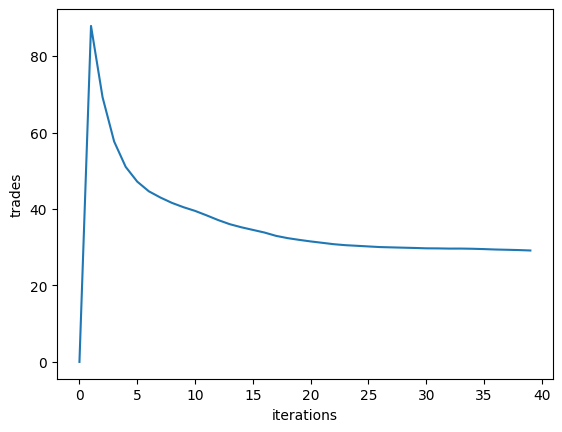

In [68]:
plt.plot(logger.getMetric("avg_trades"))
plt.xlabel("iterations")
plt.ylabel("trades")

In [13]:
torch.save(rolling_train.agent.state_dict(),"Qlearning/models/agent_roll_1.pt")

In [16]:
logger.save(path= "Qlearning/models/logger_roll_1.pt")

In [27]:
v = .8
arr = [v]
for i in range(4000):
    arr.append(v)
    v*= .999

In [29]:
v

0.014623215861991555

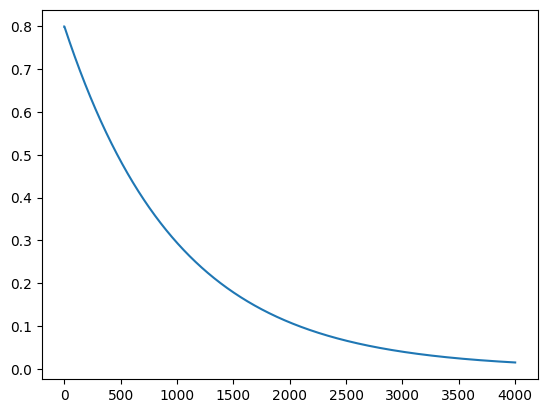

In [30]:
plt.plot(arr)